In [1]:
import cv2 #open cv 모듈 #open cv는 numpy의 자료형을 다룸
from google.colab import files #코랩에서 파일불러오기위한 모듈
from google.colab.patches import cv2_imshow #코랩에서 내놓은 cv호환패치 모듈
import numpy as np #csv에 쓰기위한 pixel정보값 생성위해 사용
from time import time, sleep #시간측정

In [2]:
#사용할 파일 불러오기
file0=files.upload()
img1=cv2.imread("Lenna.png")
print(img1.shape)
height, width, channel = img1.shape

Saving Lenna.png to Lenna.png
(512, 512, 3)


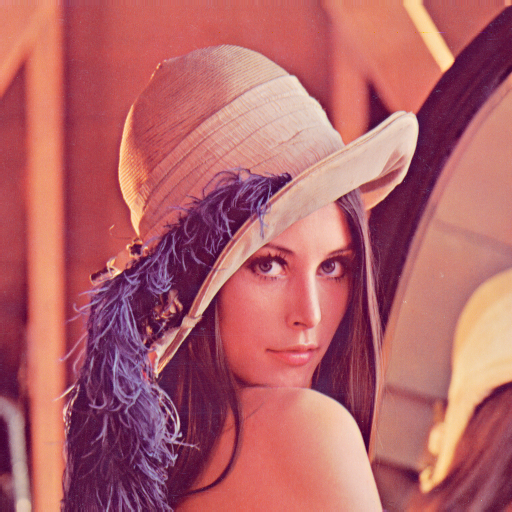

In [ ]:
#복사
copy_img=np.zeros(shape=(height,width,channel), dtype=np.uint8)
for y in range(height):
  copyimgy=copy_img[y]
  img1y=img1[y]
  for x in range(width):
    copyimgyx=copyimgy[x]
    img0yx=img1y[x]
    for z in range(channel):
       copyimgyx[z]=img0yx[z]

cv2_imshow(copy_img)

In [14]:
 #Bilinear Interpolation 쌍선형 보간법
#x: 0 n 2n 3n ~(width-1)*n, y:0 n 2 n 3n ~ (height-1)*n
def xbilinear(imgg,nx,ny,x,y):
  px=int(x-x%nx); py=int(y-y%ny)
  if x%nx==0 and y%ny==0:
    return imgg[py][px][0], imgg[py][px][1], imgg[py][px][2]
  else:
    h1=y%ny; h2=ny-h1;
    w1=x%nx; w2=nx-w1;
    a=h1/ny; b=h2/ny; p=w1/nx; q=w2/nx;
    A=imgg[py][px]
    B=imgg[py][px+1]
    C=imgg[py+1][px]
    D=imgg[py+1][px+1]
    tlst=[]
    for z in range(3):
      P=q*(b*A[z]+a*B[z])+p*(b*D[z]+a*C[z])
      tlst.append(P)

    return tlst[0], tlst[1], tlst[2]

#Bilinear Interpolation 쌍선형 보간법 사이즈 재설정
def Bilinear_Resize(이미지,x비율,y비율):
  img1=이미지
  nx=x비율
  ny=y비율
  height, width, channel = img1.shape
  n_height=int(height*ny)
  n_width=int(width*nx)
  print(n_height,n_width)
  n_img=np.zeros(shape=(n_height,n_width,channel), dtype=np.uint8)
  #반복구문에서 쓰기위해 보정
  lennx=1
  if nx>1:
    lennx=int(nx)
  lenny=1
  if ny>1:
    lenny=int(ny)


  #격자 채워넣기
  for y in range(0,n_height,lenny): #세로라서 y로 지정
    oimg=img1[int(y/ny)]
    nty=n_img[y]
    for a in range(lenny):
      iya=y+a
      if iya>=n_height:
        iya=n_height-1
      ntya=n_img[iya]
      for b in range(lennx):
        for x in range(0,(n_width-b),lennx): #가로라서 x로 지정
          ntya[x][0]=oimg[int(x/nx)][0]
          ntya[x][1]=oimg[int(x/nx)][1]
          ntya[x][2]=oimg[int(x/nx)][2]
          nty[int(x+b)][0]=oimg[int(x/nx)][0]
          nty[int(x+b)][1]=oimg[int(x/nx)][1]
          nty[int(x+b)][2]=oimg[int(x/nx)][2]

  #구역마다 채워넣기
  for y in range(0,(n_height-1),lenny): #세로라서 y로 지정
    oimg=img1[int(y/ny)]
    for a in range(1,lenny): #격자방식일때는 1부터
      nya=n_img[y+a]
      for b in range(1,lennx):  #격자방식일때는 1부터
        for x in range(0,(n_width-b),lennx): #가로라서 x로 지정
          nya[x+b][0], nya[x+b][1], nya[x+b][2]=xbilinear(n_img,nx,ny,x,y)     

  cv2_imshow(n_img)

768 768


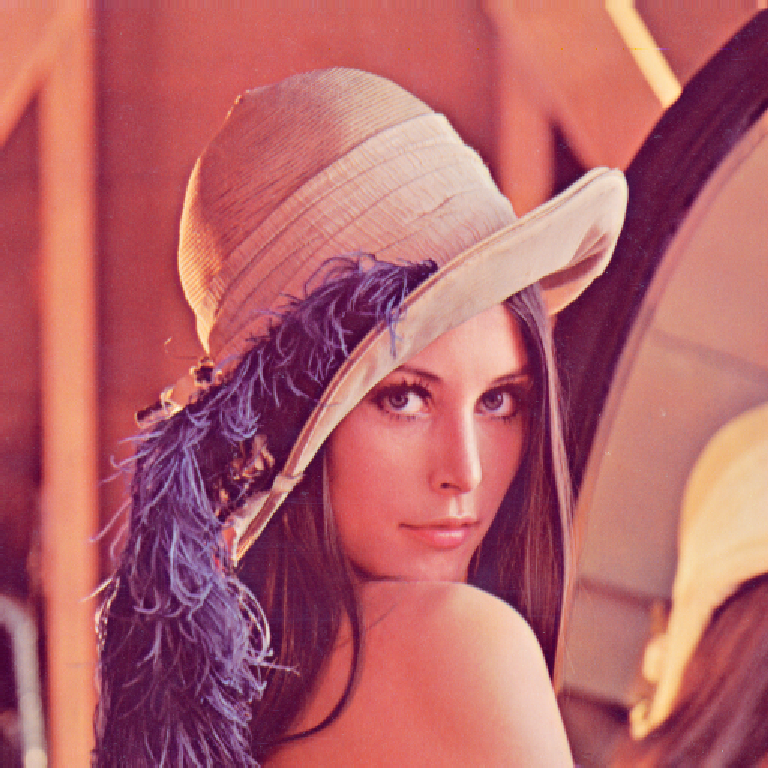

In [112]:
#구동부
"""xzoom=float(input("x 축소/확대 배율: "))
yzoom=float(input("y 축소/확대 배율: "))"""
xzoom=1.5
yzoom=1.5
Bilinear_Resize(img1,xzoom,yzoom)

1075 1075


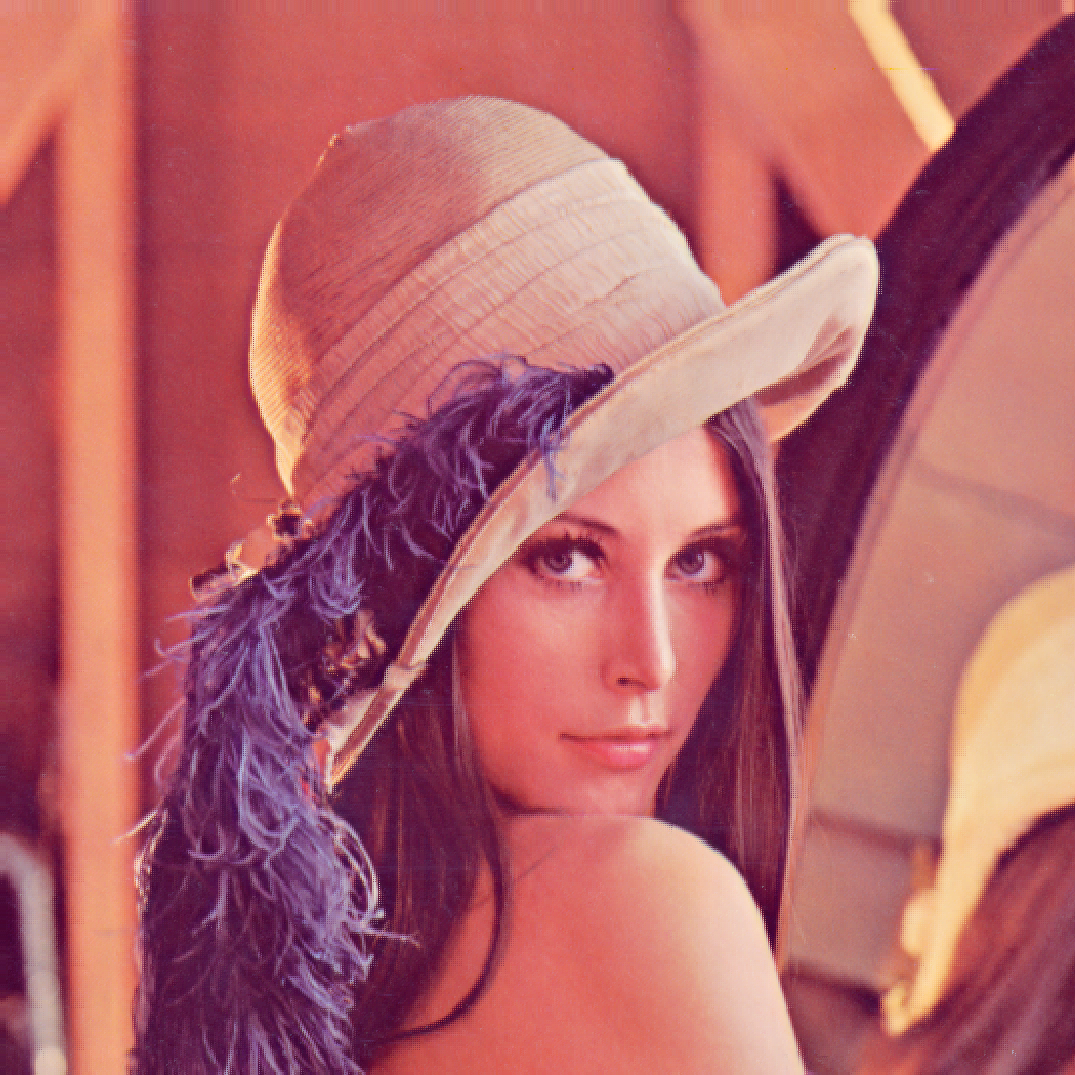

In [116]:
xzoom=2.1
yzoom=2.1
Bilinear_Resize(img1,xzoom,yzoom)

In [10]:
#위 방법은 격자로 참조값 넣은뒤 그걸 바탕으로 색상값 넣는거라서 특정비율에서 격자현상이 심함
#아예 처음부터 원본에서 가져오게 변형해서 작동시키는게 목적
def obilinear(oimg,nx,ny,x,y): #nx
  oheight, owidth, ochannel = oimg.shape
  px=int((x-x%nx)/nx); py=int((y-y%ny)/ny)
  if px+1>=owidth:
    px=owidth-2
  if py+1>=oheight:
    py=oheight-2

  if x%nx==0 and y%ny==0:
    return oimg[py][px][0], oimg[py][px][1], oimg[py][px][2]
  else:
    h1=y%ny; h2=ny-h1;
    w1=x%nx; w2=nx-w1;
    a=h1/ny; b=h2/ny; 
    p=w1/nx; q=w2/nx;
    A=oimg[py][px].astype(np.uint16) #uint8는 최댓값이 255까지이기때문에 연산중에 에러발생가능 uint16으로 타입바꾸면 색상값 처리중에 에러 발생할일이 없다.
    B=oimg[py][px+1].astype(np.uint16)
    C=oimg[py+1][px].astype(np.uint16)
    D=oimg[py+1][px+1].astype(np.uint16)
    tlst=[]
    for z in range(3):
      P=q*(b*A[z]+a*B[z])+p*(b*D[z]+a*C[z])
      tlst.append(P)

    return tlst[0], tlst[1], tlst[2]

#Bilinear Interpolation 쌍선형 보간법 사이즈 재설정
def Bilinear_Resize2(이미지,x비율,y비율):
  img1=이미지
  nx=x비율
  ny=y비율
  height, width, channel = img1.shape
  n_height=int(height*ny)
  n_width=int(width*nx)
  print(n_height,n_width)
  n_img=np.zeros(shape=(n_height,n_width,channel), dtype=np.uint8)
  #반복구문에서 쓰기위해 보정
  lennx=1
  if nx>1:
    lennx=int(nx)
  lenny=1
  if ny>1:
    lenny=int(ny)

  #점으로 채워넣기
  for y in range(n_height): #세로라서 y로 지정
    nimgy=n_img[y]
    for x in range(n_width): #가로라서 x로 지정
      nimgy[x][0], nimgy[x][1], nimgy[x][2]=obilinear(img1,nx,ny,x,y)     
  

  cv2_imshow(n_img)

In [15]:
xzoom=2
yzoom=2
print("기존 함수")
Bilinear_Resize(img1,xzoom,yzoom)
print("개량 함수")
Bilinear_Resize2(img1,xzoom,yzoom)
#기존 방법에 비해 잡티는 줄었지만 경계선이 더 두드러짐

Output hidden; open in https://colab.research.google.com to view.

In [17]:
xzoom=2.2
yzoom=2.2
print("기존 함수")
Bilinear_Resize(img1,xzoom,yzoom)
print("개량 함수")
Bilinear_Resize2(img1,xzoom,yzoom)

Output hidden; open in https://colab.research.google.com to view.

In [18]:
xzoom=2.1
yzoom=2.1
print("기존 함수")
Bilinear_Resize(img1,xzoom,yzoom)
print("개량 함수")
Bilinear_Resize2(img1,xzoom,yzoom)

Output hidden; open in https://colab.research.google.com to view.